In [1]:
# import necessary library
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np
import geopandas as gpd
from shapely.geometry import Point # Point class
from shapely.geometry import shape
import networkx as nx
import osmnx as ox
import os 
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
import shapely.geometry as geom
import shapely.wkt

C:\Users\mmmiah\AppData\Local\ESRI\conda\envs\geo_env\Lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_2272\457341533.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https:

In [2]:
# Helper Function
def min_distance_ppoly(point, polygon):
    return polygon.distance(point).min()


# Calculate Weekly and Monthly Total Traffic

In [3]:
# Import estimated daily Volume
DV=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_DV_feb19.csv')
DV=DV.drop(['level_0','index'],axis=1)
DV.head()

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
0,2014.0,E,Thursday,5.0,6191,37.916293,-122.026658,323.429092
1,2014.0,N,Thursday,5.0,6274,37.919106,-122.065131,44.209732
2,2014.0,S,Thursday,5.0,6002,37.916497,-122.027719,51.190216
3,2014.0,S,Thursday,5.0,6127,37.917992,-122.065518,44.209732
4,2014.0,S,Thursday,5.0,6192,37.884941,-122.077718,20.941452


In [4]:
check=DV.loc[DV['TDV']==0]
check

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
1083,2016.0,E,Tuesday,10.0,155814,37.647773,-122.105862,0.0
1084,2016.0,E,Tuesday,10.0,157583,37.737660,-122.187827,0.0
1451,2017.0,E,Thursday,11.0,155517,37.678738,-122.050562,0.0
1482,2017.0,N,Thursday,11.0,155502,37.679466,-122.051132,0.0
1515,2017.0,S,Thursday,10.0,155349,37.573216,-122.055051,0.0
1527,2017.0,S,Wednesday,9.0,156097,37.700623,-122.143895,0.0
1543,2017.0,W,Thursday,11.0,155504,37.678968,-122.051940,0.0
1611,2018.0,E,Tuesday,10.0,155814,37.647773,-122.105862,0.0
1616,2018.0,E,Tuesday,10.0,157583,37.737660,-122.187827,0.0
1822,2018.0,S,Wednesday,10.0,156097,37.700623,-122.143895,0.0


In [5]:
DV.isnull().sum()

year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [6]:
# import pop, CBD and Strava
stv=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Sc_Stv_pop_CBD.csv')
stv=stv.rename(columns={'tdg_id':'matched_seg_id'})
stv.tail(2)

,Unnamed: 0.1,matched_seg_id,year,Unnamed: 0,ID,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
5702,5702,66187.0,2014.0,5478,Eric_Fischer893,S,34.266245,-118.313146,308135633.0,13291814.0,NaN,NaN,NaN,NaN,0.0,POINT (155306.06124027242 -415248.5251424038),5304.864322
5703,5703,64988.0,2014.0,5571,Eric_Fischer986,E,34.066455,-118.469556,307724323.0,203650462.0,NaN,NaN,NaN,NaN,0.0,POINT (141264.8749155821 -437655.1388520058),6901.823725


In [7]:
stv1=stv[['matched_seg_id','year','stv_rec_ratio','popden']]
stv1.shape

(5704, 4)

In [8]:
DV1=pd.merge(DV,stv1, left_on=['matched_seg_id','year'],right_on=['matched_seg_id','year'],how='inner')
DV1.shape

(6790, 10)

In [9]:
DV['matched_seg_id'].nunique(),stv['matched_seg_id'].nunique(),DV1['matched_seg_id'].nunique()

(2569, 3608, 2568)

In [10]:
# Now find the short term sites that did not match
common = stv.merge(DV,on=['matched_seg_id', 'year'])
ch=stv[(~stv.matched_seg_id.isin(common.matched_seg_id))]
ch.head()

,Unnamed: 0.1,matched_seg_id,year,Unnamed: 0,ID,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
0,0,60313.0,2014.0,0,Eric_Fischer1089,N,34.062543,-118.309114,307766980.0,47895363.0,3905.0,865.0,3040.0,NaN,0.778489,POINT (156080.15249454585 -437837.2709260313),31855.628241
1,1,60316.0,2014.0,1,Eric_Fischer1089,E,34.061703,-118.308480,307766746.0,398048051.0,4970.0,1885.0,3085.0,NaN,0.620724,POINT (156140.3601590143 -437929.3106884626),32550.878297
2,2,60314.0,2014.0,2,Eric_Fischer1089,S,34.061193,-118.309105,307766737.0,398053760.0,2050.0,620.0,1430.0,NaN,0.697561,POINT (156083.63949423961 -437986.95203821827),31741.126338
3,3,60320.0,2014.0,3,Eric_Fischer1089,W,34.061700,-118.309727,307766743.0,398048057.0,3560.0,1830.0,1730.0,NaN,0.485955,POINT (156025.2604089025 -437931.73530244455),30898.086056
4,4,44255.0,2014.0,4,Eric_Fischer1086,E,34.090759,-118.308870,307771629.0,398048112.0,2390.0,905.0,1485.0,NaN,0.621339,POINT (156046.88371409217 -434707.3058124846),26375.825438


In [11]:
ch['matched_seg_id'].unique()

array([60313., 60316., 60314., ..., 55028., 66187., 64988.])

In [12]:
# Lets separate sites that have Strava RR 
DV1['popden'].isnull().sum(),DV1['stv_rec_ratio'].isnull().sum()
# it seems 13 sites hass popden missing or zero pop density and 3673  have missing SRR

(0, 0)

In [13]:
DV1['popden'].fillna(1, inplace=True)

In [14]:
DV1p1=DV1.loc[DV1['stv_rec_ratio']>=0]
DV1p2=DV1[DV1['stv_rec_ratio'].isnull()]

In [15]:
DV1.shape,DV1p1.shape,DV1p2.shape 

((6790, 10), (6790, 10), (0, 10))

In [16]:
# Now estimate SRR using the formula.
# a=0.96967
# b=-0.00303
# c=0.02395
# DV1p2['stv_rec_ratio']=a+b*np.sqrt(DV1p2['popden'])+c*np.log(DV1p2['CBD Distance'])
# DV1p2.head()

In [17]:
# now combine with rest of the data that have already SRR
DV3=DV1p1
DV3.shape

(6790, 10)

In [18]:
# Now calculate the WWI index using WWI= 0.54311-0.04492* ln(population Density) + 0.60716 *〖"(Strava Recreational Ratio)" 〗^𝟐
a=0.54311
b=-0.04492
c=0.60716
DV3['WWI']=a+b*np.log(DV3['popden'])+c*np.power(DV3['stv_rec_ratio'],2)

In [19]:
# Split the data by WWI threshold to apply DOW factor
w_g1=DV3.loc[DV3['WWI']<=0.40]
w_g2=DV3.loc[DV3['WWI']>0.40]
w_g2.tail(2)

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV,stv_rec_ratio,popden,WWI
6788,2019.0,W,Saturday,6.0,80666,39.140724,-120.155743,48.103565,0.937500,226.820272,0.833094
6789,2019.0,W,Saturday,7.0,80797,39.237589,-120.028389,229.169103,0.977744,674.983342,0.830905


In [20]:
# read DOW factor
DOW=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Final Factor/Final_DOW_Factor.csv')
DOW.head()

,Unnamed: 0,Day of Week,Average_Group_DOW_Factor,criteria
0,0,Monday,0.157756,WWI<=0.40
1,1,Tuesday,0.172408,WWI<=0.40
2,2,Wednesday,0.168993,WWI<=0.40
3,3,Thursday,0.161938,WWI<=0.40
4,4,Friday,0.145688,WWI<=0.40


In [21]:
DOW_g1=DOW.loc[DOW['criteria']=='WWI<=0.40']
DOW_g2=DOW.loc[DOW['criteria']=='WWI>0.40']

In [22]:
# Calculate weekly Volume for group 1
wg1_DV=pd.merge(w_g1,DOW_g1, on=['Day of Week'], how='inner')
wg1_DV1=pd.DataFrame({'agge_Weekly_Volume' : wg1_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['TDV'].sum()}).reset_index()
wg1_DV1f=pd.DataFrame({'agge_factor' : wg1_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Average_Group_DOW_Factor'].sum()}).reset_index()
wg1_DV1r=pd.merge(wg1_DV1,wg1_DV1f, on=['year','Leg','month','matched_seg_id','Lat','Long'], how='inner')
wg1_DV1r['Weekly_Volume']=wg1_DV1r['agge_Weekly_Volume']/wg1_DV1r['agge_factor']
wg1_DV1rf=pd.DataFrame({'TWV' : wg1_DV1r.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()

In [23]:
c=wg1_DV.loc[wg1_DV['TDV']==0]
c1=wg1_DV1.loc[wg1_DV1['agge_Weekly_Volume']==0]
c.shape,c1.shape

((5, 14), (5, 7))

In [24]:
# Calculate weekly Volume for group 2
wg2_DV=pd.merge(w_g2,DOW_g2, on=['Day of Week'], how='inner')
wg2_DV2=pd.DataFrame({'agge_Weekly_Volume' : wg2_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['TDV'].sum()}).reset_index()
wg2_DV2f=pd.DataFrame({'agge_factor' : wg2_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Average_Group_DOW_Factor'].sum()}).reset_index()
wg2_DV2r=pd.merge(wg2_DV2,wg2_DV2f, on=['year','Leg','month','matched_seg_id','Lat','Long'], how='inner')
wg2_DV2r['Weekly_Volume']=wg2_DV2r['agge_Weekly_Volume']/wg2_DV2r['agge_factor']
wg2_DV2rf=pd.DataFrame({'TWV' : wg2_DV2r.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()

In [25]:
c=wg2_DV.loc[wg2_DV['TDV']==0]
c1=wg2_DV2.loc[wg2_DV2['agge_Weekly_Volume']==0]
c.shape,c1.shape

((21, 14), (21, 7))

In [26]:
wg2_DV.head()

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV,stv_rec_ratio,popden,WWI,Unnamed: 0,Average_Group_DOW_Factor,criteria
0,2014.0,E,Thursday,5.0,6191,37.916293,-122.026658,323.429092,0.967676,3574.017778,0.744142,3,0.126624,WWI>0.40
1,2014.0,N,Thursday,5.0,6274,37.919106,-122.065131,44.209732,0.793651,6404.168560,0.531838,3,0.126624,WWI>0.40
2,2014.0,S,Thursday,5.0,6002,37.916497,-122.027719,51.190216,0.953779,3637.433372,0.727140,3,0.126624,WWI>0.40
3,2014.0,S,Thursday,5.0,6127,37.917992,-122.065518,44.209732,0.740741,6241.750126,0.483700,3,0.126624,WWI>0.40
4,2014.0,S,Thursday,5.0,6192,37.884941,-122.077718,20.941452,0.943190,3911.200091,0.711684,3,0.126624,WWI>0.40


In [27]:
# Apply factor to obtain weekly Total Volume Volume
# wg1_DV=pd.merge(w_g1,DOW_g1, on=['Day of Week'], how='inner')
# wg1_DV['Weekly_Volume']=wg1_DV['TDV']/wg1_DV['Average_Group_DOW_Factor']
# wg1_DV1=pd.DataFrame({'TWV' : wg1_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()
# wg2_DV=pd.merge(w_g2,DOW_g2, on=['Day of Week'], how='inner')
# wg2_DV['Weekly_Volume']=wg2_DV['TDV']/wg2_DV['Average_Group_DOW_Factor']
# wg2_DV2=pd.DataFrame({'TWV' : wg2_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()


In [28]:
# c=wg2_DV2.loc[wg2_DV2['TWV']==0]
# c1=wg1_DV1.loc[wg1_DV1['TWV']==0]
# c.shape,c1.shape

In [29]:
# combine these three group of estimated daily volume together
WV=pd.concat([wg1_DV1rf,wg2_DV2rf],axis=0).reset_index()
WV.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV
0,0,2014.0,E,1.0,53084,34.036725,-118.268227,2223.468070
1,1,2014.0,E,2.0,60365,34.094931,-118.308130,3024.141066
2,2,2014.0,E,5.0,63070,34.029300,-118.409925,1902.043304
3,3,2014.0,E,6.0,63070,34.029300,-118.409925,1426.532478
4,4,2014.0,E,7.0,13963,40.804708,-124.148768,267.329681


In [30]:
WV['matched_seg_id'].nunique()

2568

In [31]:
wg2_DV.isnull().sum()

year                        0
Leg                         0
Day of Week                 0
month                       0
matched_seg_id              0
Lat                         0
Long                        0
TDV                         0
stv_rec_ratio               0
popden                      0
WWI                         0
Unnamed: 0                  0
Average_Group_DOW_Factor    0
criteria                    0
dtype: int64

In [32]:
# Now divide TWV by 7 to get the weekley average volume
WV['AWV']=WV['TWV']/7
WV['year'] = WV['year'].apply(np.int64)
WV['month'] = WV['month'].apply(np.int64)
WV.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV
0,0,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296
1,1,2014,E,2,60365,34.094931,-118.308130,3024.141066,432.020152
2,2,2014,E,5,63070,34.029300,-118.409925,1902.043304,271.720472
3,3,2014,E,6,63070,34.029300,-118.409925,1426.532478,203.790354
4,4,2014,E,7,13963,40.804708,-124.148768,267.329681,38.189954


In [33]:
# Now calculate the number of days in data collection month and multiple average weekly volume (AWV) to get monthly total volume
# create dummy day column to get the date and days in month
WV['day']=1
cols=["year","month","day"]
WV['date'] = WV[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
WV['date'] = pd.to_datetime(WV['date'], errors='coerce')
WV['days_in_month'] = WV['date'].dt.days_in_month
WV.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month
0,0,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31
1,1,2014,E,2,60365,34.094931,-118.308130,3024.141066,432.020152,1,2014-02-01,28
2,2,2014,E,5,63070,34.029300,-118.409925,1902.043304,271.720472,1,2014-05-01,31
3,3,2014,E,6,63070,34.029300,-118.409925,1426.532478,203.790354,1,2014-06-01,30
4,4,2014,E,7,13963,40.804708,-124.148768,267.329681,38.189954,1,2014-07-01,31


In [34]:
WV['MTT']=WV['AWV']*WV['days_in_month']
WV['MTT'].describe()

count     3676.000000
mean      4970.971406
std       7276.881680
min          0.000000
25%       1156.725886
50%       2507.817644
75%       5450.710968
max      89166.878345
Name: MTT, dtype: float64

In [35]:
WV.isnull().sum()

index             0
year              0
Leg               0
month             0
matched_seg_id    0
Lat               0
Long              0
TWV               0
AWV               0
day               0
date              0
days_in_month     0
MTT               0
dtype: int64

In [36]:
check=WV.loc[WV['MTT']==0]
check

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT
322,322,2016,N,10,150133,37.568146,-121.973536,0.0,0.0,1,2016-10-01,31,0.0
586,586,2017,N,11,155319,37.542417,-122.047910,0.0,0.0,1,2017-11-01,30,0.0
658,658,2017,W,9,157528,37.773863,-122.221284,0.0,0.0,1,2017-09-01,30,0.0
982,982,2018,W,10,157375,37.793646,-122.227237,0.0,0.0,1,2018-10-01,31,0.0
983,983,2018,W,10,157528,37.773863,-122.221284,0.0,0.0,1,2018-10-01,31,0.0
1733,641,2016,E,10,155814,37.647773,-122.105862,0.0,0.0,1,2016-10-01,31,0.0
1744,652,2016,E,10,157583,37.737660,-122.187827,0.0,0.0,1,2016-10-01,31,0.0
1975,883,2016,N,10,156921,37.806382,-122.250017,0.0,0.0,1,2016-10-01,31,0.0
2544,1452,2017,E,11,155517,37.678738,-122.050562,0.0,0.0,1,2017-11-01,30,0.0
2545,1453,2017,E,11,155614,37.671424,-122.082380,0.0,0.0,1,2017-11-01,30,0.0


<AxesSubplot: >

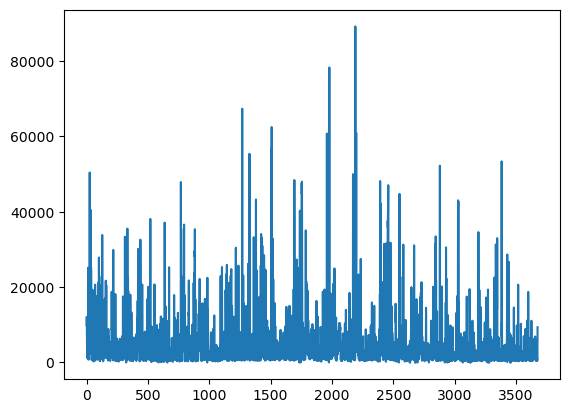

In [37]:
WV['MTT'].plot()

In [38]:
check=WV.loc[WV['MTT']>200000]
check

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT


# Now Estimate Annual Total Traffic

In [39]:
# read the moy factor
MOY=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Final Factor/Final_MOY_Factor.csv')
MOY.head()

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
0,0,1,0.067719,seasonal_factor<=2.4
1,1,2,0.071112,seasonal_factor<=2.4
2,2,3,0.080148,seasonal_factor<=2.4
3,3,4,0.087425,seasonal_factor<=2.4
4,4,5,0.091053,seasonal_factor<=2.4


In [40]:
MOY['Criteria'].unique()

array(['seasonal_factor<=2.4', '2.4<seasonal_factor<=5',
       'seasonal_factor>5'], dtype=object)

In [41]:
# Now split the data by group
moy_g1=MOY.loc[MOY['Criteria']=='seasonal_factor<=2.4']
moy_g2=MOY.loc[MOY['Criteria']=='2.4<seasonal_factor<=5']
moy_g3=MOY.loc[MOY['Criteria']=='seasonal_factor>5']
moy_g3.head(2)

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
24,0,1,0.021449,seasonal_factor>5
25,1,2,0.018644,seasonal_factor>5


In [42]:
# Calculate the seasonality factor and check how many sites have data to calculate it
# get June/July/August Data
dos678=DV[(DV['month']>5) &(DV['month']<9)]
dos678=dos678[['matched_seg_id','year','Leg','TDV']]
dos678c=pd.DataFrame({'Average Daily Count678' : dos678.groupby(['matched_seg_id','year','Leg'])['TDV'].mean()}).reset_index()
dos678c.head()

,matched_seg_id,year,Leg,Average Daily Count678
0,6447,2014.0,S,30.070687
1,6893,2015.0,N,71.779543
2,7119,2017.0,E,64.427432
3,7175,2017.0,N,1190.231671
4,7211,2016.0,W,152.579892


In [43]:
# get December/January/February Data
dos12=DV.loc[DV['month']==12]
dos1=DV.loc[DV['month']==1]
dos3=DV.loc[DV['month']==2]
dos1213=pd.concat([dos12,dos1,dos3],axis=0)
dos1213=dos1213[['matched_seg_id','year',"Leg",'TDV']]
dos12131=pd.DataFrame({'Average Daily Count12131' : dos1213.groupby(['matched_seg_id','year','Leg'])['TDV'].mean()}).reset_index()
dos12131.head()

,matched_seg_id,year,Leg,Average Daily Count12131
0,2183,2018.0,N,23.948430
1,2185,2018.0,W,28.837404
2,2186,2018.0,E,42.576426
3,5820,2019.0,S,72.248933
4,5861,2019.0,N,72.248933


In [44]:
seasonal_data=pd.merge(dos12131,dos678c, left_on=['matched_seg_id','year','Leg'],right_on=['matched_seg_id','year','Leg'],how='inner')
seasonal_data['seasonal_factor']=seasonal_data['Average Daily Count678']/seasonal_data['Average Daily Count12131']
seasonal_data=seasonal_data[['matched_seg_id','year','Leg','seasonal_factor']]
seasonal_data.head()

,matched_seg_id,year,Leg,seasonal_factor


In [45]:
# It seems none of the sites have data to calculate the seasonality, therefore used geohrahic classification to assign the
#seasonality group. Use the closest distance to assign the seasonal group
g1=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Revised_Seasonality/Group1.shp')
g1['group']='seasonal_factor<=2.4'
g2=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Revised_Seasonality/Group2.shp')
g2['group']='2.4<seasonal_factor<=5'
g3=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Revised_Seasonality/Group3.shp')
g3['group']='seasonal_factor>5'
# combine all
s_g=pd.concat([g1,g2,g3],axis=0)
#s_g['group'] = s_g['group'].apply(np.int64)
s_g.head()

,Field1,ID,latitude,longitude,location,road,city,county,state,country,Average_se,geometry,group
0,0,671,37.791160,-122.459440,urban,Bay Area Ridge Trail,San Francisco,None,California,United States,1.268874,POINT (-122.45944 37.79116),seasonal_factor<=2.4
1,1,1127,37.796165,-122.419490,urban,Broadway,San Francisco,None,California,United States,1.012863,POINT (-122.41949 37.79617),seasonal_factor<=2.4
2,2,2415,37.774200,-122.436295,urban,Fell Street,San Francisco,None,California,United States,1.407406,POINT (-122.43629 37.77420),seasonal_factor<=2.4
3,3,2694,33.683254,-117.662080,urban,Torino Drive,None,Orange County,California,United States,1.359999,POINT (-117.66208 33.68325),seasonal_factor<=2.4
4,4,2695,33.672590,-117.651860,urban,Serrano Road,None,Orange County,California,United States,1.515797,POINT (-117.65186 33.67259),seasonal_factor<=2.4


In [46]:
s_g.groupby(['group'])['ID'].count()

group
2.4<seasonal_factor<=5      6
seasonal_factor<=2.4      152
seasonal_factor>5           6
Name: ID, dtype: int64

In [47]:
s_g.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [48]:
WV1 = gpd.GeoDataFrame(WV, geometry=gpd.points_from_xy(WV.Long, WV.Lat))
WV1.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry
0,0,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31,9846.787165,POINT (-118.26823 34.03673)
1,1,2014,E,2,60365,34.094931,-118.308130,3024.141066,432.020152,1,2014-02-01,28,12096.564263,POINT (-118.30813 34.09493)
2,2,2014,E,5,63070,34.029300,-118.409925,1902.043304,271.720472,1,2014-05-01,31,8423.334630,POINT (-118.40993 34.02930)
3,3,2014,E,6,63070,34.029300,-118.409925,1426.532478,203.790354,1,2014-06-01,30,6113.710619,POINT (-118.40993 34.02930)
4,4,2014,E,7,13963,40.804708,-124.148768,267.329681,38.189954,1,2014-07-01,31,1183.888587,POINT (-124.14877 40.80471)


In [49]:
crs = {'init': 'epsg:4326'}
WV2 = gpd.GeoDataFrame(WV1, crs=crs, geometry = 'geometry')
WV2.head()

C:\Users\mmmiah\AppData\Local\ESRI\conda\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry
0,0,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31,9846.787165,POINT (-118.26823 34.03673)
1,1,2014,E,2,60365,34.094931,-118.308130,3024.141066,432.020152,1,2014-02-01,28,12096.564263,POINT (-118.30813 34.09493)
2,2,2014,E,5,63070,34.029300,-118.409925,1902.043304,271.720472,1,2014-05-01,31,8423.334630,POINT (-118.40993 34.02930)
3,3,2014,E,6,63070,34.029300,-118.409925,1426.532478,203.790354,1,2014-06-01,30,6113.710619,POINT (-118.40993 34.02930)
4,4,2014,E,7,13963,40.804708,-124.148768,267.329681,38.189954,1,2014-07-01,31,1183.888587,POINT (-124.14877 40.80471)


In [50]:
# project the co-ordinate
WV2_proj = WV2.to_crs(epsg=3310).reset_index()
s_g_proj = s_g.to_crs(epsg=3310).reset_index()

In [51]:
def nearest_point(point, point2):
    idx = point2.geometry.distance(point).idxmin()
    return point2.loc[idx,'group']

In [52]:
WV2_proj['group'] = WV2_proj.geometry.apply(nearest_point, point2=s_g_proj)
WV2_proj.head()

,level_0,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
0,0,0,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31,9846.787165,POINT (159906.171 -440632.482),seasonal_factor<=2.4
1,1,1,2014,E,2,60365,34.094931,-118.308130,3024.141066,432.020152,1,2014-02-01,28,12096.564263,POINT (156106.916 -434243.408),seasonal_factor<=2.4
2,2,2,2014,E,5,63070,34.029300,-118.409925,1902.043304,271.720472,1,2014-05-01,31,8423.334630,POINT (146837.500 -441685.442),seasonal_factor<=2.4
3,3,3,2014,E,6,63070,34.029300,-118.409925,1426.532478,203.790354,1,2014-06-01,30,6113.710619,POINT (146837.500 -441685.442),seasonal_factor<=2.4
4,4,4,2014,E,7,13963,40.804708,-124.148768,267.329681,38.189954,1,2014-07-01,31,1183.888587,POINT (-350090.339 317483.532),2.4<seasonal_factor<=5


In [53]:
# Now split the data by group
m_g1=WV2_proj.loc[WV2_proj['group']=='seasonal_factor<=2.4']
m_g2=WV2_proj.loc[WV2_proj['group']=='2.4<seasonal_factor<=5']
m_g3=WV2_proj.loc[WV2_proj['group']=='seasonal_factor>5']
m_g3.head(2)

,level_0,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
63,63,63,2015,E,8,8904,38.87892,-120.019933,1357.058416,193.865488,1,2015-08-01,31,6009.830129,POINT (-1726.986 95881.088),seasonal_factor>5
64,64,64,2015,E,9,8904,38.87892,-120.019933,86.612514,12.373216,1,2015-09-01,30,371.196487,POINT (-1726.986 95881.088),seasonal_factor>5


In [54]:
# Calculate Annual Volume for group 1
mg1_DV=pd.merge(m_g1,moy_g1, on=['month'], how='inner')
mg1_DV1=pd.DataFrame({'agge_monthly_Volume' : mg1_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg1_DV1f=pd.DataFrame({'agge_factor' : mg1_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg1_DV1r=pd.merge(mg1_DV1,mg1_DV1f, on=['year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg1_DV1r['Annual_Volume']=mg1_DV1r['agge_monthly_Volume']/mg1_DV1r['agge_factor']
mg1_DV1rf=pd.DataFrame({'ATT' : mg1_DV1r.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [55]:
mg1_DV.shape,mg1_DV1.shape

((3510, 19), (3429, 6))

In [56]:
c=mg1_DV.loc[mg1_DV['MTT']==0]
c1=mg1_DV1.loc[mg1_DV1['agge_monthly_Volume']==0]
c.shape,c1.shape

((26, 19), (26, 6))

In [57]:
# Calculate Annual Volume for group 1
mg2_DV=pd.merge(m_g2,moy_g2, on=['month'], how='inner')
mg2_DV2=pd.DataFrame({'agge_monthly_Volume' : mg2_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg2_DV2f=pd.DataFrame({'agge_factor' : mg2_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg2_DV2r=pd.merge(mg2_DV2,mg2_DV2f, on=['year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg2_DV2r['Annual_Volume']=mg2_DV2r['agge_monthly_Volume']/mg2_DV2r['agge_factor']
mg2_DV2rf=pd.DataFrame({'ATT' : mg2_DV2r.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [58]:
# Calculate Annual Volume for group 1
mg3_DV=pd.merge(m_g3,moy_g3, on=['month'], how='inner')
mg3_DV3=pd.DataFrame({'agge_monthly_Volume' : mg3_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg3_DV3f=pd.DataFrame({'agge_factor' : mg3_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg3_DV3r=pd.merge(mg3_DV3,mg3_DV3f, on=['year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg3_DV3r['Annual_Volume']=mg3_DV3r['agge_monthly_Volume']/mg3_DV3r['agge_factor']
mg3_DV3rf=pd.DataFrame({'ATT' : mg3_DV3r.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [59]:
# Now apply the MOY factor to get ATT
# Apply factor to obtain daily Volume
# mg1_DV=pd.merge(m_g1,moy_g1, on=['month'], how='inner')
# mg1_DV['Annual_Volume']=mg1_DV['MTT']/mg1_DV['Average_Group_MOY_Factor']
# mg1_DV1=pd.DataFrame({'ATT' : mg1_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg2_DV=pd.merge(m_g2,moy_g2, on=['month'], how='inner')
# mg2_DV['Annual_Volume']=mg2_DV['MTT']/mg2_DV['Average_Group_MOY_Factor']
# mg2_DV2=pd.DataFrame({'ATT' : mg2_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg3_DV=pd.merge(m_g3,moy_g3, on=['month'], how='inner')
# mg3_DV['Annual_Volume']=mg3_DV['MTT']/mg3_DV['Average_Group_MOY_Factor']
# mg3_DV3=pd.DataFrame({'ATT' : mg3_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg3_DV3.head()

In [60]:
# mg1_DV.tail(10)

In [61]:
# combine these three group of estimated Annual volume together
AV=pd.concat([mg1_DV1rf,mg2_DV2rf,mg3_DV3rf],axis=0).reset_index()
AV.ATT = AV.ATT.round()
AV.head()

,index,year,Leg,matched_seg_id,Lat,Long,ATT
0,0,2014,E,6191,37.916293,-122.026658,124231.0
1,1,2014,E,6234,37.885158,-122.077300,17640.0
2,2,2014,E,49197,34.049795,-117.815552,11809.0
3,3,2014,E,49209,34.043425,-117.846269,13160.0
4,4,2014,E,53084,34.036725,-118.268227,145406.0


In [62]:
# bring back the location id
idf=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Processed Data/short_term_clean_data_2014_2019.csv')
idf=idf[['ID',"matched_seg_id"]]
idf1=idf.drop_duplicates(subset=["matched_seg_id"], keep='first')
idf1.shape

(4264, 2)

In [63]:
AV1=pd.merge(AV, idf1, on=['matched_seg_id'], how='inner')
AV1.shape

(3569, 8)

In [64]:
# now check unique location for each year
AV1.groupby(['year'])['ID'].nunique()

year
2014    105
2015    137
2016    485
2017    305
2018    455
2019    219
Name: ID, dtype: int64

In [65]:
AV1['ID'].nunique()

1333

In [66]:
AV=AV.loc[AV['Lat']!=0]
AV['ATT in Million']=AV['ATT']/1000000
AV.head()

,index,year,Leg,matched_seg_id,Lat,Long,ATT,ATT in Million
0,0,2014,E,6191,37.916293,-122.026658,124231.0,0.124231
1,1,2014,E,6234,37.885158,-122.077300,17640.0,0.017640
2,2,2014,E,49197,34.049795,-117.815552,11809.0,0.011809
3,3,2014,E,49209,34.043425,-117.846269,13160.0,0.013160
4,4,2014,E,53084,34.036725,-118.268227,145406.0,0.145406


In [67]:
c=AV.loc[AV['ATT']==0]
c.shape

(26, 8)

In [68]:
AV['ATT in Million'].max()

1.186858

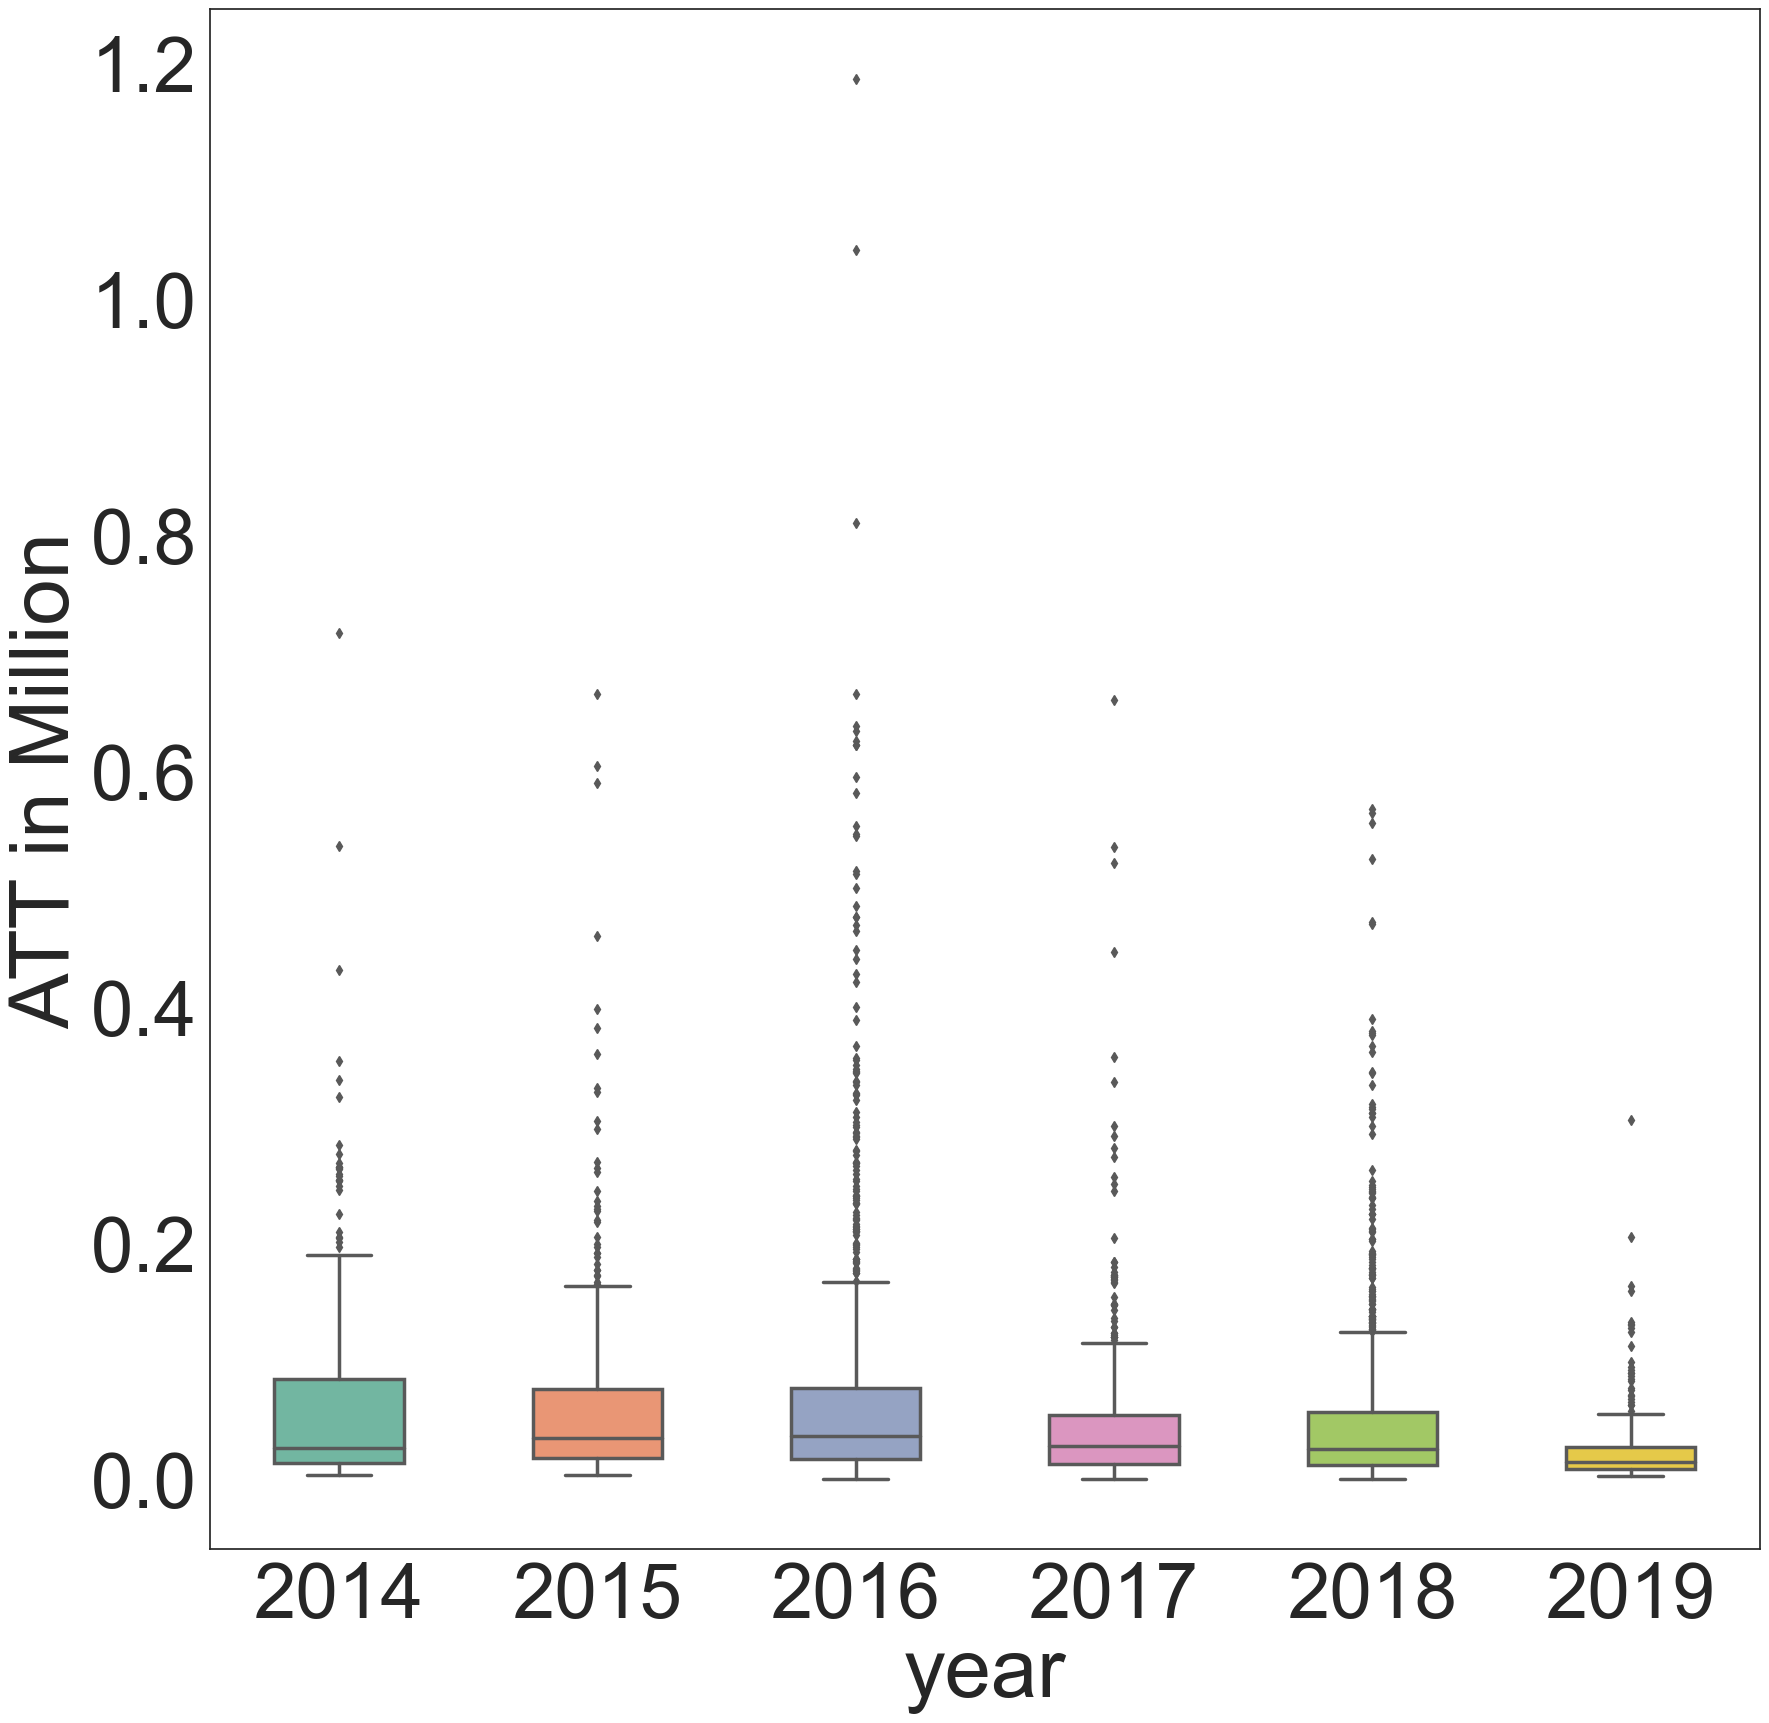

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,20)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=5, color_codes=False, rc=None)
ax=sns.boxplot( x=AV["year"], y=AV["ATT in Million"],width=0.5,linewidth=2.5,orient="v",palette="Set2" );
#sns.stripplot(data=AV, x="year", y="ATT in Million", dodge=True, ax=ax)
plt.show()

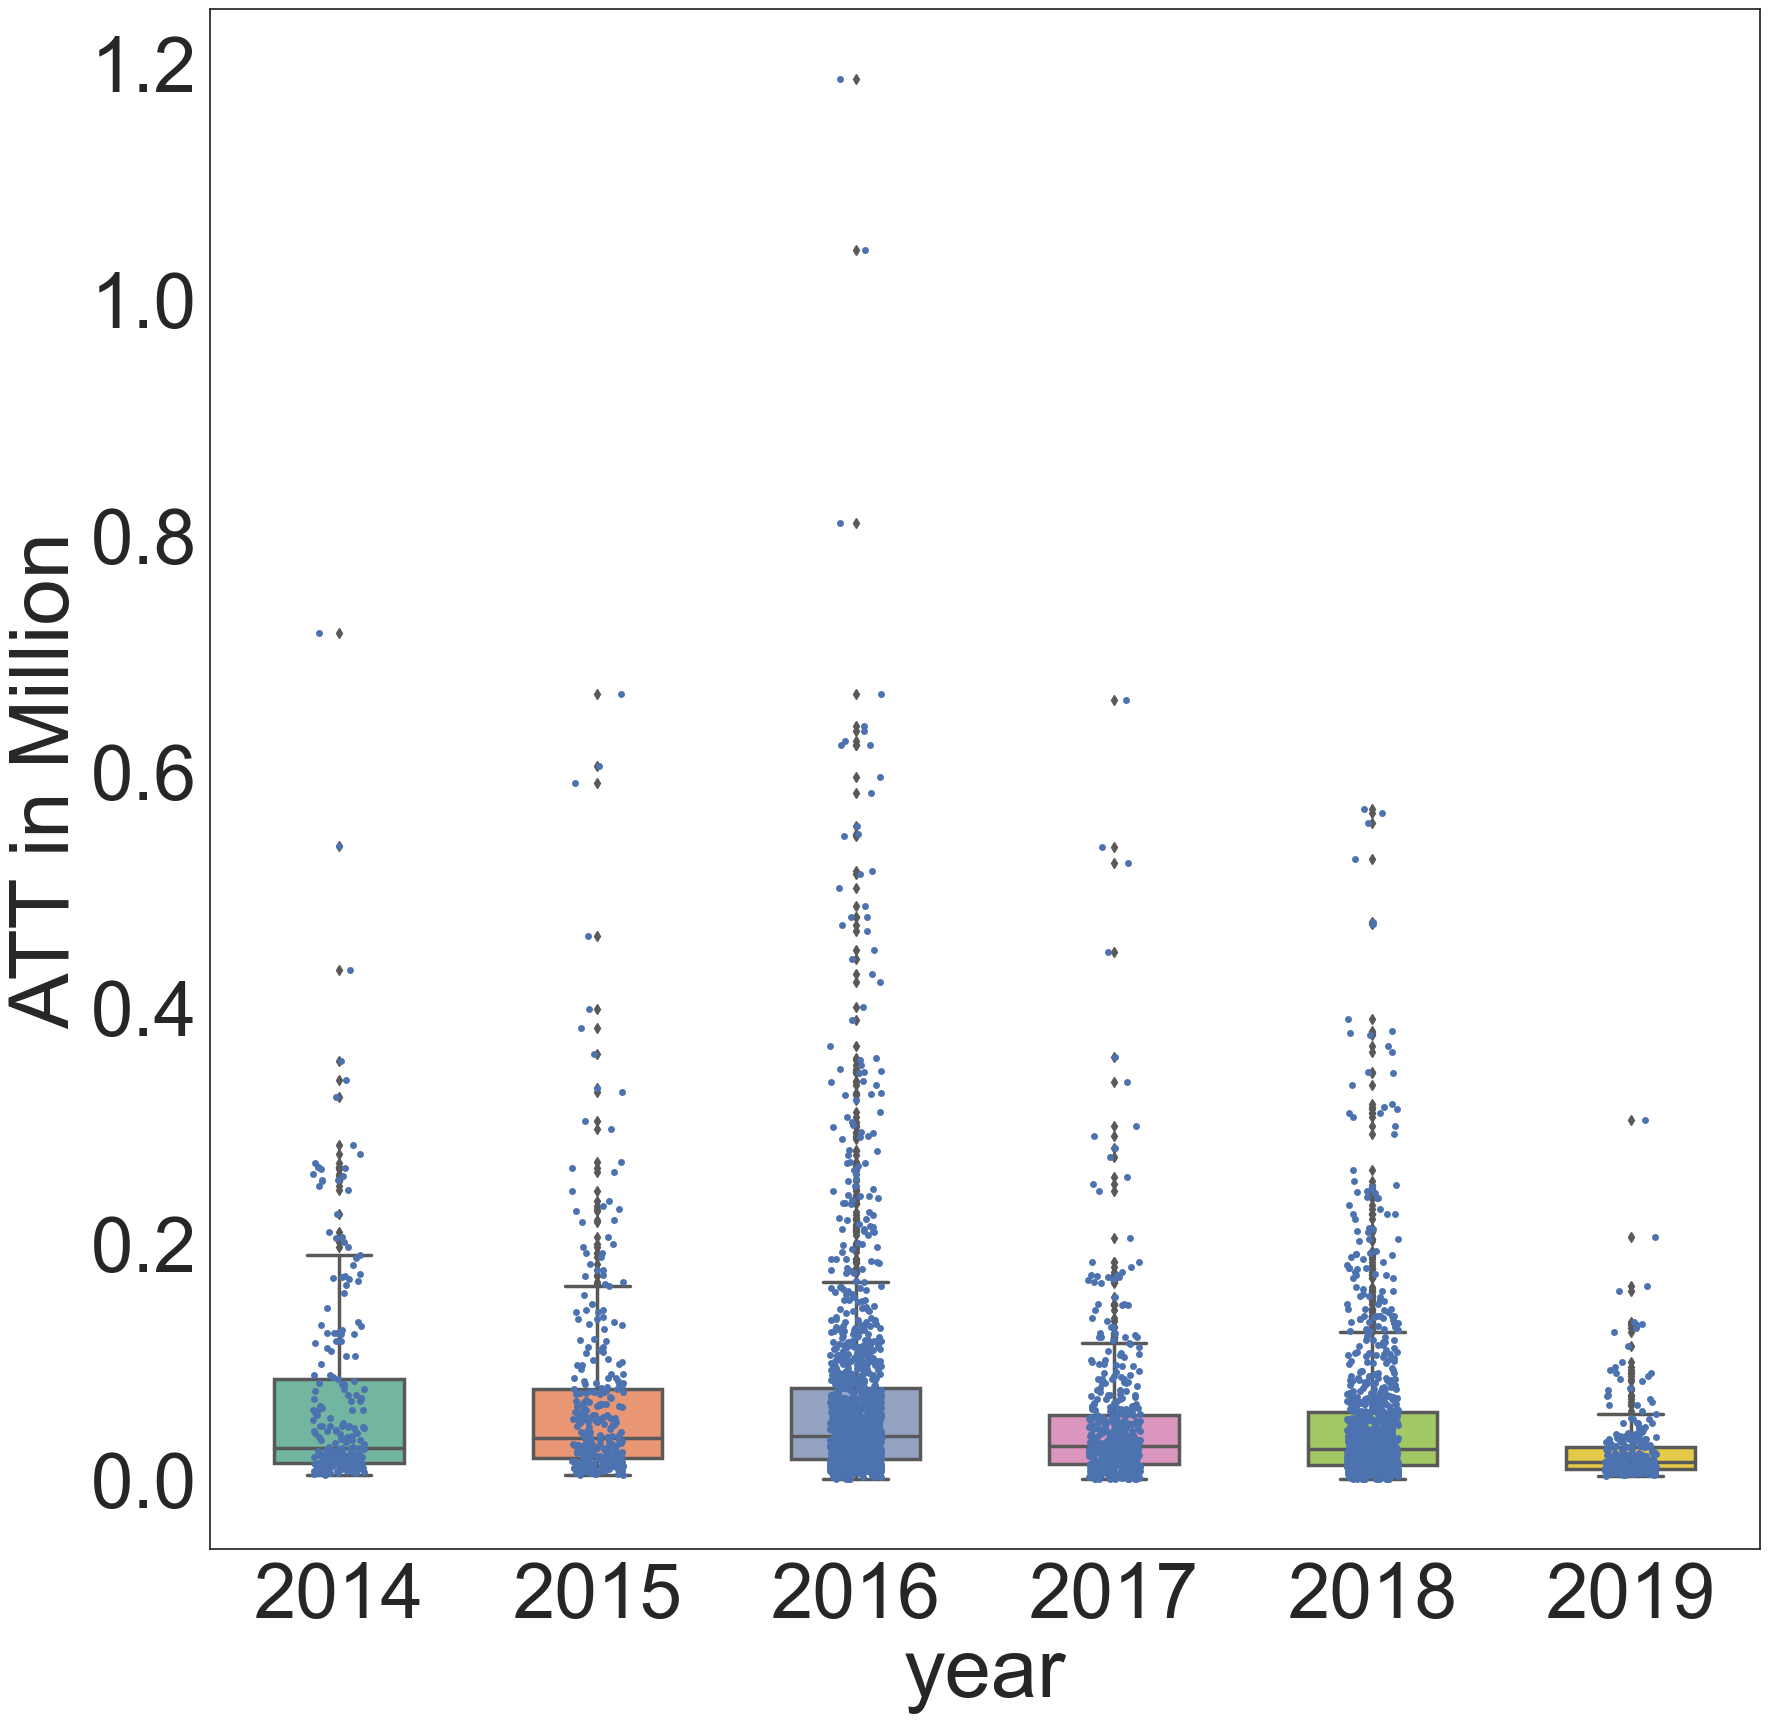

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,20)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=5, color_codes=False, rc=None)
ax=sns.boxplot( x=AV["year"], y=AV["ATT in Million"],width=0.5,linewidth=2.5,orient="v",palette="Set2" );
sns.stripplot(data=AV, x="year", y="ATT in Million", dodge=True, ax=ax)
plt.show()

In [72]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(rc={'figure.figsize':(20,20)})
# sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=5, color_codes=False, rc=None)
# # filter the data and exclude the sites that have more than million count
# data=AV.loc[AV['ATT in Million']<=1]
# sns.boxplot( x=data["year"], y=data["ATT in Million"],width=0.50,linewidth=2.5,orient="v",palette="Set2");
# plt.show()

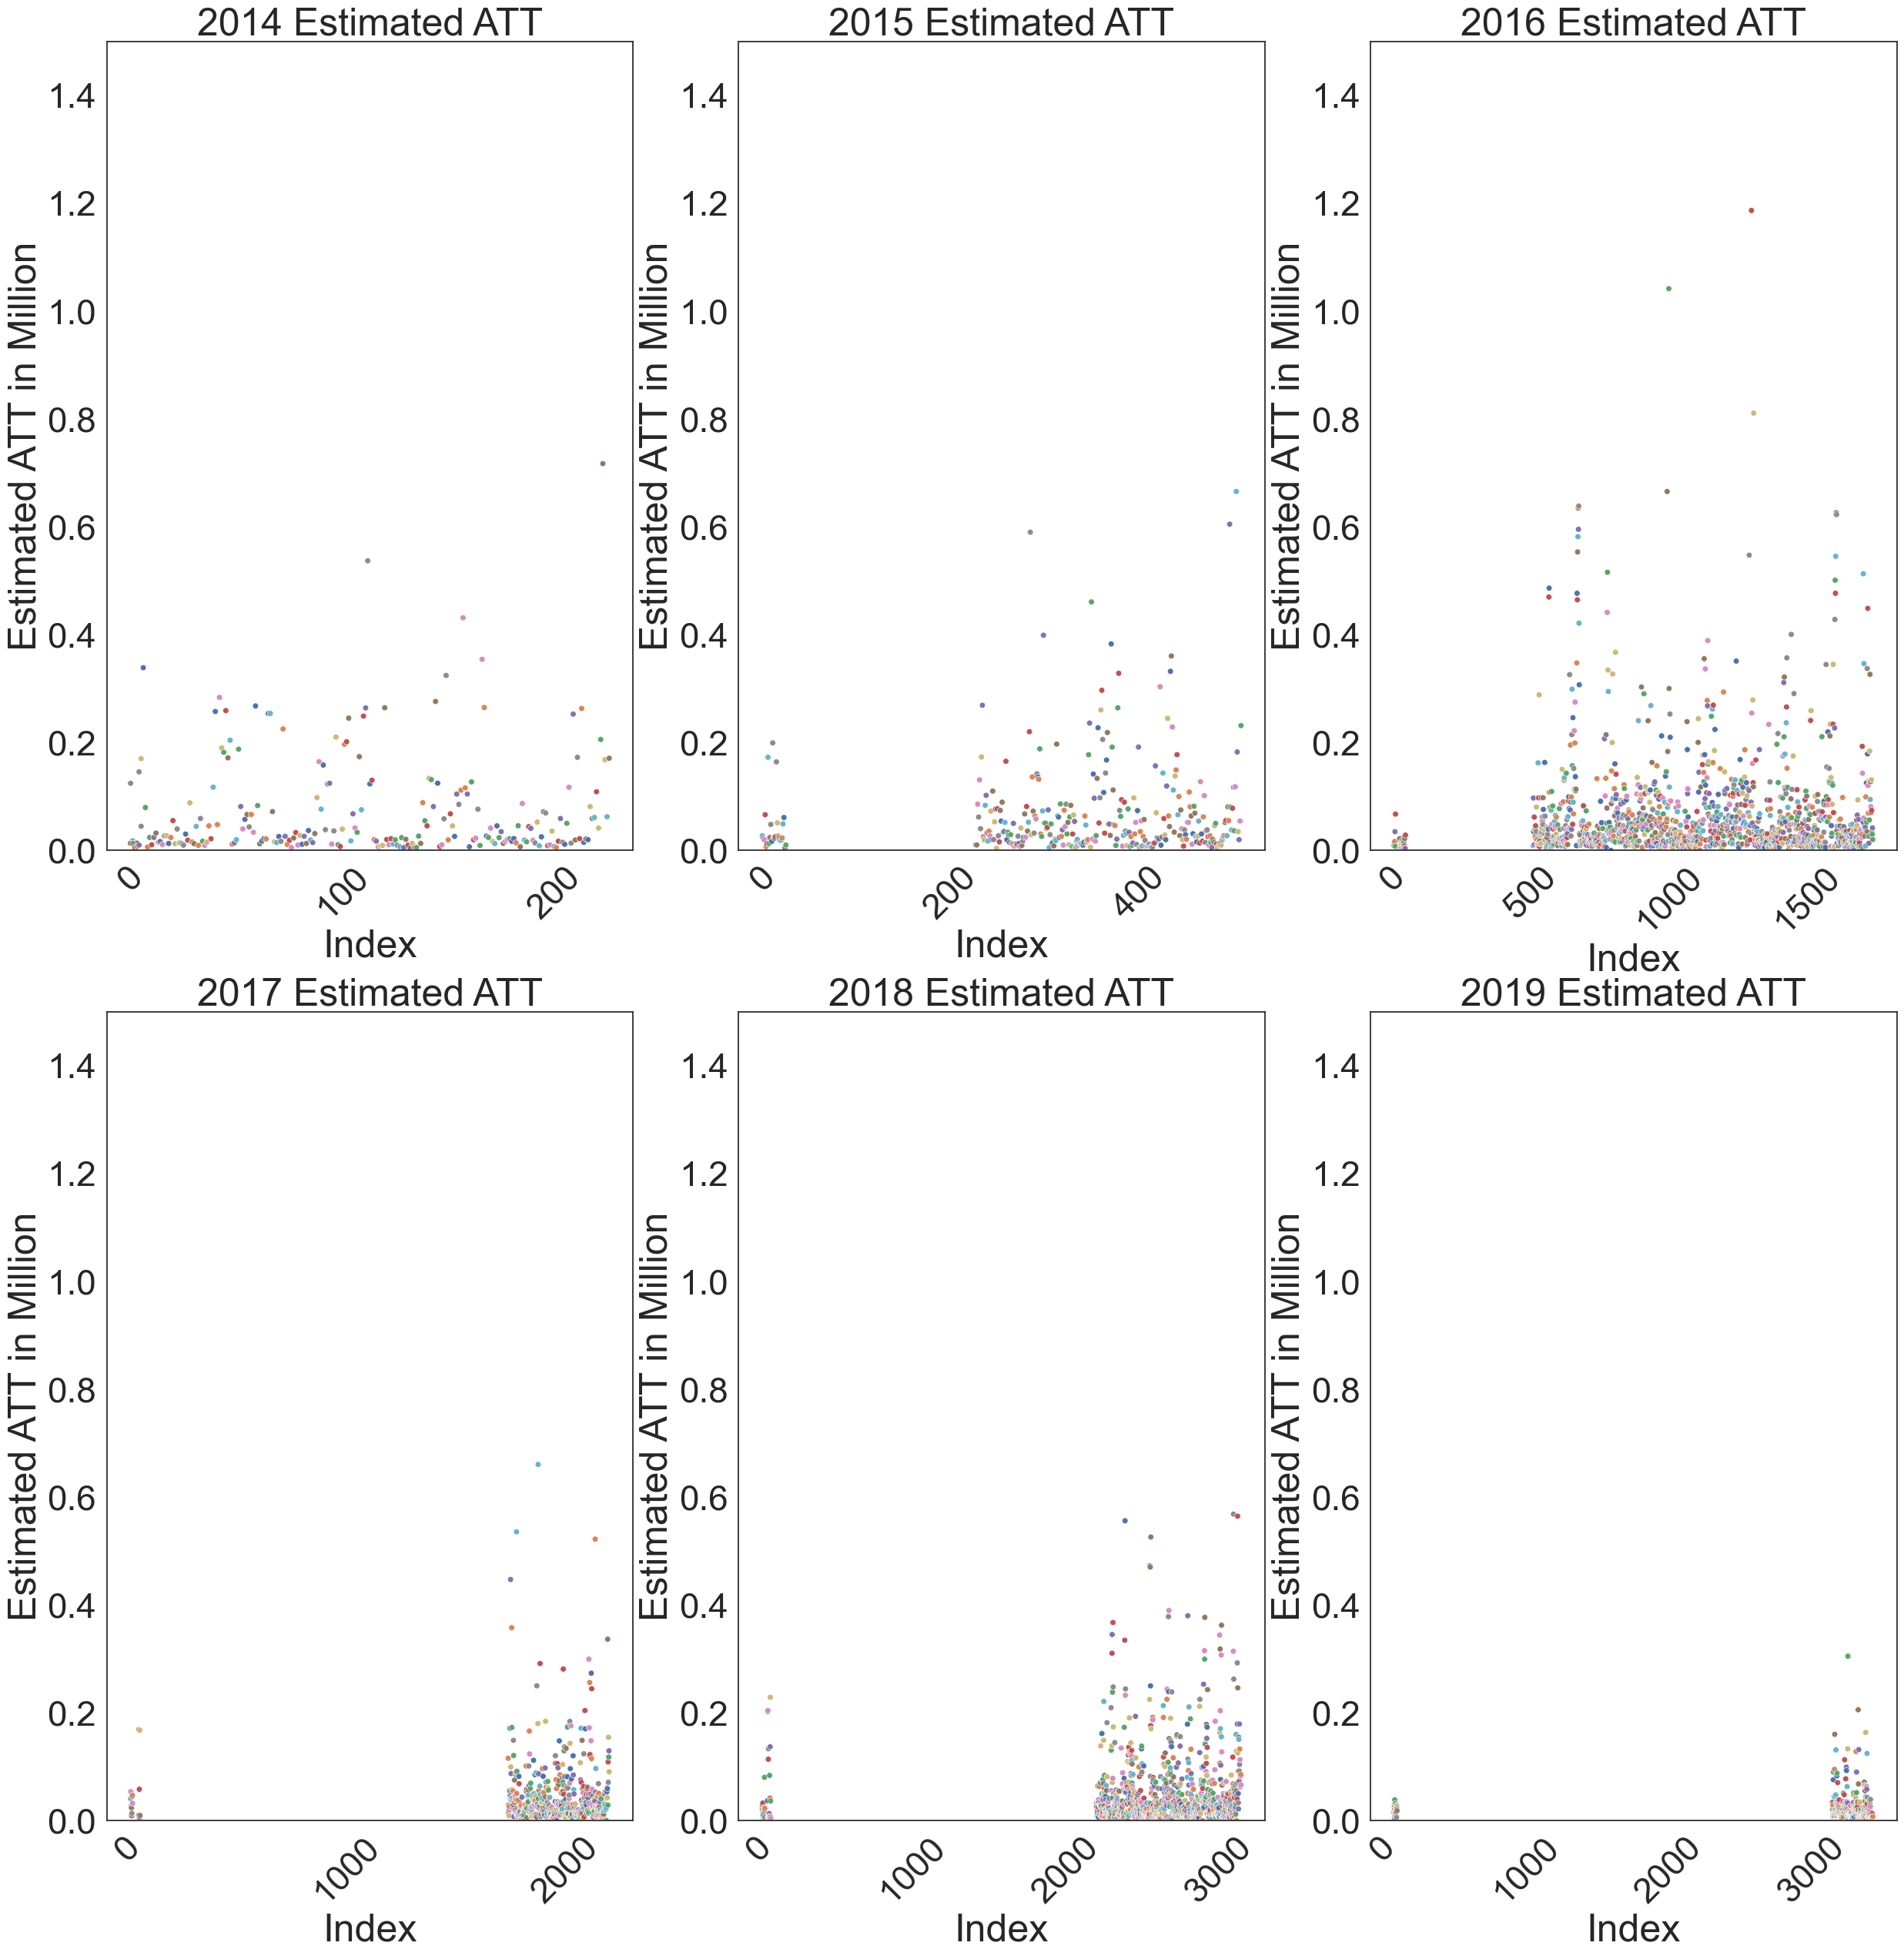

In [74]:
sns.set(rc={'figure.figsize':(30,30)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=3, color_codes=False, rc=None)
#sns.set(font_scale=3.0)
#sns.set_theme(style='white')
import seaborn as sns
d14=AV.loc[AV['year']==2014]
d15=AV.loc[AV['year']==2015]
d16=AV.loc[AV['year']==2016]
d17=AV.loc[AV['year']==2017]
d18=AV.loc[AV['year']==2018]
d19=AV.loc[AV['year']==2019]
fig, ax = plt.subplots(2,3) 

ax1 = sns.scatterplot(x=d14['index'],y=d14['ATT in Million'],hue=d14['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.scatterplot(x=d15['index'],y=d15['ATT in Million'],hue=d15['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.scatterplot(x=d16['index'],y=d16['ATT in Million'],hue=d16['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[0,2]) 
plt.xticks(rotation = 'vertical')
ax4 = sns.scatterplot(x=d17['index'],y=d17['ATT in Million'],hue=d17['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[1,0]) 
plt.xticks(rotation = 'vertical')
ax5 = sns.scatterplot(x=d18['index'],y=d18['ATT in Million'],hue=d18['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[1,1])
plt.xticks(rotation = 'vertical')
ax6 = sns.scatterplot(x=d19['index'],y=d19['ATT in Million'],hue=d19['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[1,2]) 
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()


ax1.set_ylim([0, 1.5])
ax2.set_ylim([0, 1.5])
ax3.set_ylim([0, 1.5])
ax4.set_ylim([0, 1.5])
ax5.set_ylim([0, 1.5])
ax6.set_ylim([0, 1.5])
ax1.ticklabel_format(style='plain', axis='both')
ax2.ticklabel_format(style='plain', axis='both')
ax3.ticklabel_format(style='plain', axis='both')
ax4.ticklabel_format(style='plain', axis='both')
ax5.ticklabel_format(style='plain', axis='both')
ax6.ticklabel_format(style='plain', axis='both')

ax1.title.set_text('2014 Estimated ATT')
ax2.title.set_text('2015 Estimated ATT')
ax3.title.set_text('2016 Estimated ATT')
ax4.title.set_text('2017 Estimated ATT')
ax5.title.set_text('2018 Estimated ATT')
ax6.title.set_text('2019 Estimated ATT')

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45)

ax1.set_ylabel('Estimated ATT in Million' )
ax1.set_xlabel('Index')
ax2.set_ylabel('Estimated ATT in Million' )
ax2.set_xlabel('Index')
ax3.set_ylabel('Estimated ATT in Million' )
ax3.set_xlabel('Index')
ax4.set_ylabel('Estimated ATT in Million' )
ax4.set_xlabel('Index')
ax5.set_ylabel('Estimated ATT in Million' )
ax5.set_xlabel('Index')
ax6.set_ylabel('Estimated ATT in Million' )
ax6.set_xlabel('Index')
plt.show()

In [75]:
AV.groupby(['year'])['Leg'].count()

year
2014     233
2015     310
2016    1259
2017     481
2018     982
2019     304
Name: Leg, dtype: int64

In [76]:
AV['Leg'].count()

3569

In [77]:
AV.groupby(['year','Leg'])['ATT'].describe().round()

count     mean       std     min      25%      50%       75%  \
year Leg                                                                 
2014 E     62.0  70173.0   82774.0  5981.0  14090.0  30929.0   82519.0   
     N     56.0  84277.0  102577.0  4930.0  16408.0  33075.0  125774.0   
     S     47.0  63986.0   91551.0  3813.0   9591.0  20344.0   86694.0   
     W     68.0  67534.0  107848.0  5084.0  16132.0  24368.0   63977.0   
2015 E     79.0  66003.0   88506.0  3535.0  19552.0  33432.0   75175.0   
     N     74.0  70305.0   83379.0  4734.0  16697.0  41118.0   85028.0   
     S     84.0  75263.0   91160.0  4707.0  18291.0  33495.0   94595.0   
     W     73.0  62311.0  105154.0  4023.0  19376.0  36186.0   63695.0   
2016 E    319.0  72069.0  110976.0     0.0  16946.0  31858.0   73730.0   
     N    339.0  63606.0   89558.0     0.0  16025.0  38297.0   79205.0   
     S    293.0  71726.0  106324.0  1779.0  19326.0  43405.0   84776.0   
     W    308.0  68718.0  104066.0  2053.0  16401.0  33128.0   69334.0   
2017 E    104.0  52831.0   78830.0     0.0  15158.0  30506.0   54956.0   
     N    140.0  43357.0   68586.0     0.0  12106.0  25978.0   48790.0   
     S    117.0  46736.0   50599.0     0.0  12928.0  26896.0   63440.0   
     W    120.0  53971.0   75672.0     0.0  16850.0  29885.0   49798.0   
2018 E    248.0  54237.0   71785.0     0.0  14151.0  30191.0   60642.0   
     N    267.0  50549.0   75324.0     0.0  11426.0  23577.0   52834.0   
     S    240.0  46478.0   61590.0     0.0  11010.0  23714.0   50222.0   
     W    227.0  55121.0   80758.0     0.0  12088.0  28094.0   62772.0   
2019 E     74.0  26291.0   29898.0  4149.0   9526.0  14659.0   28912.0   
     N     79.0  26316.0   40083.0  3043.0   8730.0  14737.0   27718.0   
     S     74.0  25466.0   31806.0  3840.0   9072.0  17084.0   28822.0   
     W     77.0  22008.0   25562.0  3599.0   7712.0  13223.0   25849.0   

                max  
year Leg             
2014 E     338721.0  
     N     536996.0  
     S     431334.0  
     W     717346.0  
2015 E     589984.0  
     N     460750.0  
     S     382834.0  
     W     665596.0  
2016 E     638475.0  
     N    1041928.0  
     S    1186858.0  
     W     626190.0  
2017 E     535647.0  
     N     660656.0  
     S     281049.0  
     W     522134.0  
2018 E     556253.0  
     N     525990.0  
     S     379956.0  
     W     568468.0  
2019 E     159991.0  
     N     304905.0  
     S     205571.0  
     W     163462.0

In [78]:
AV.groupby(['year'])['matched_seg_id'].count()

year
2014     233
2015     310
2016    1259
2017     481
2018     982
2019     304
Name: matched_seg_id, dtype: int64

In [79]:
AV.groupby(['year'])['matched_seg_id'].nunique()

year
2014     226
2015     306
2016    1204
2017     479
2018     957
2019     291
Name: matched_seg_id, dtype: int64

In [80]:
AV['matched_seg_id'].nunique()

2568

In [81]:
AV.shape

(3569, 8)

In [82]:
# Save the estimation
AV.to_csv('H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_ATT_feb19.csv',index=False)

In [90]:
# Now join with independent variables
indv=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Independent Variables/smart4_final_output_Feb14_2023.csv')
indv['forward_trip_count']=(indv['forward_trip_count_2018']+indv['forward_trip_count_2019'])/2
indv['reverse_trip_count']=(indv['reverse_trip_count_2018']+indv['reverse_trip_count_2019'])/2
indv['forward_commute_trip_count']=(indv['forward_commute_trip_count_2018']+indv['forward_commute_trip_count_2019'])/2
indv['reverse_commute_trip_count']=(indv['reverse_commute_trip_count_2018']+indv['reverse_commute_trip_count_2019'])/2
indv['forward_leisure_trip_count']=(indv['forward_leisure_trip_count_2018']+indv['forward_leisure_trip_count_2019'])/2
indv['reverse_leisure_trip_count']=(indv['reverse_leisure_trip_count_2018']+indv['reverse_leisure_trip_count_2019'])/2
indv['forward_average_speed']=(indv['forward_average_speed_2018']+indv['forward_average_speed_2019'])/2
indv['reverse_average_speed']=(indv['reverse_average_speed_2018']+indv['reverse_average_speed_2019'])/2
indv.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_2272\3454974825.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  indv=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Independent Variables/smart4_final_output_Feb14_2023.csv')


,segment_id,street_name,county,tdg_id,lrs_cal_id,bikes_proh,bike_facs,int_tdg_id,loc_id,seg_counter,...,lt_o_shd_tot_width,near_strava_id,forward_trip_count,reverse_trip_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,reverse_average_speed
0,151228.0,SR-88-ALPINE,Alpine,1,3381,0,NaN,NaN,NaN,NaN,...,2.0,311390673,1355.0,1327.5,10.0,10.0,1345.0,1317.5,9.845,6.570
1,151230.0,El Camino Sierra,Alpine,3,3381,0,NaN,NaN,NaN,NaN,...,0.0,311390789,1267.5,1090.0,12.5,7.5,1255.0,1082.5,13.525,1.255
2,151231.0,El Camino Sierra,Alpine,4,3381,0,NaN,NaN,NaN,NaN,...,0.0,311390793,1242.5,1052.5,12.5,7.5,1230.0,1045.0,12.530,4.325
3,151232.0,Douglas Way,Alpine,5,0,0,NaN,NaN,NaN,NaN,...,NaN,311390792,10.0,10.0,0.0,0.0,10.0,10.0,2.915,3.005
4,151233.0,Snowshoe Springs Road,Alpine,6,0,0,NaN,NaN,NaN,NaN,...,0.0,311390809,2.5,2.5,0.0,0.0,2.5,2.5,2.315,0.875


In [91]:
list(indv.columns)

['segment_id',
 'street_name',
 'county',
 'tdg_id',
 'lrs_cal_id',
 'bikes_proh',
 'bike_facs',
 'int_tdg_id',
 'loc_id',
 'seg_counter',
 'fclass',
 'tasas_ids',
 'ataip_ids',
 'fc_draft',
 'speed',
 'slope',
 'empnum_density_t',
 'nearbyuniversity_t',
 'bgarea_t',
 'bgcliparea_t',
 'pctofbgarea_t',
 'pctwhite_t',
 'totwhitepersqmi_t',
 'pctbiketowork_t',
 'totbiketoworkpersqmi_t',
 'pctatleastbachelors_t',
 'totatleastbachelorspersqmi_t',
 'pctnoveh_t',
 'totnovehpersqmi_t',
 'popdensitysqmi_t',
 'hshlddensitysqmi_t',
 'bgarea_q',
 'bgcliparea_q',
 'pctofbgarea_q',
 'pctwhite_q',
 'totwhitepersqmi_q',
 'pctbiketowork_q',
 'totbiketoworkpersqmi_q',
 'pctatleastbachelors_q',
 'totatleastbachelorspersqmi_q',
 'pctnoveh_q',
 'totnovehpersqmi_q',
 'popdensitysqmi_q',
 'hshlddensitysqmi_q',
 'bgarea_h',
 'bgcliparea_h',
 'pctofbgarea_h',
 'pctwhite_h',
 'totwhitepersqmi_h',
 'pctbiketowork_h',
 'totbiketoworkpersqmi_h',
 'pctatleastbachelors_h',
 'totatleastbachelorspersqmi_h',
 'pctnoveh

In [92]:
# melt the strava data by year in vertical directions
indv18=indv.drop(['forward_trip_count_2019',
 'reverse_trip_count_2019',
 'forward_commute_trip_count_2019',
 'reverse_commute_trip_count_2019',
 'forward_leisure_trip_count_2019',
 'reverse_leisure_trip_count_2019',
 'forward_average_speed_2019',
 'reverse_average_speed_2019',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021','forward_trip_count',
 'reverse_trip_count',
 'forward_commute_trip_count',
 'reverse_commute_trip_count',
 'forward_leisure_trip_count',
 'reverse_leisure_trip_count',
 'forward_average_speed',
 'reverse_average_speed'],axis=1)
indv18['year']=2018
indv18=indv18.rename(columns={'forward_trip_count_2018':'forward_trip_count','reverse_trip_count_2018':'reverse_trip_count',
 'forward_commute_trip_count_2018':'forward_commute_trip_count',
 'reverse_commute_trip_count_2018':'reverse_commute_trip_count',
 'forward_leisure_trip_count_2018':'forward_leisure_trip_count',
 'reverse_leisure_trip_count_2018':'reverse_leisure_trip_count',
 'forward_average_speed_2018':'forward_average_speed',
 'reverse_average_speed_2018':'reverse_average_speed' })

In [93]:
indv19=indv.drop(['forward_trip_count_2018',
 'reverse_trip_count_2018',
 'forward_commute_trip_count_2018',
 'reverse_commute_trip_count_2018',
 'forward_leisure_trip_count_2018',
 'reverse_leisure_trip_count_2018',
 'forward_average_speed_2018',
 'reverse_average_speed_2018',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021','forward_trip_count',
 'reverse_trip_count',
 'forward_commute_trip_count',
 'reverse_commute_trip_count',
 'forward_leisure_trip_count',
 'reverse_leisure_trip_count',
 'forward_average_speed',
 'reverse_average_speed'],axis=1)
indv19['year']=2019
indv19=indv19.rename(columns={'forward_trip_count_2019':'forward_trip_count','reverse_trip_count_2019':'reverse_trip_count',
 'forward_commute_trip_count_2019':'forward_commute_trip_count',
 'reverse_commute_trip_count_2019':'reverse_commute_trip_count',
 'forward_leisure_trip_count_2019':'forward_leisure_trip_count',
 'reverse_leisure_trip_count_2019':'reverse_leisure_trip_count',
 'forward_average_speed_2019':'forward_average_speed',
 'reverse_average_speed_2019':'reverse_average_speed' })

In [94]:
# Take the average of 2018 and 2019 strava for 2014-2017
indv14=indv.drop(['forward_trip_count_2018',
 'reverse_trip_count_2018',
 'forward_commute_trip_count_2018',
 'reverse_commute_trip_count_2018',
 'forward_leisure_trip_count_2018',
 'reverse_leisure_trip_count_2018',
 'forward_average_speed_2018',
 'reverse_average_speed_2018',
 'forward_trip_count_2019',
 'reverse_trip_count_2019',
 'forward_commute_trip_count_2019',
 'reverse_commute_trip_count_2019',
 'forward_leisure_trip_count_2019',
 'reverse_leisure_trip_count_2019',
 'forward_average_speed_2019',
 'reverse_average_speed_2019',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021'],axis=1)
indv14['year']=2014

In [95]:
# Take the average of 2018 and 2019 strava for 2014-2017
indv15=indv.drop(['forward_trip_count_2018',
 'reverse_trip_count_2018',
 'forward_commute_trip_count_2018',
 'reverse_commute_trip_count_2018',
 'forward_leisure_trip_count_2018',
 'reverse_leisure_trip_count_2018',
 'forward_average_speed_2018',
 'reverse_average_speed_2018',
 'forward_trip_count_2019',
 'reverse_trip_count_2019',
 'forward_commute_trip_count_2019',
 'reverse_commute_trip_count_2019',
 'forward_leisure_trip_count_2019',
 'reverse_leisure_trip_count_2019',
 'forward_average_speed_2019',
 'reverse_average_speed_2019',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021'],axis=1)
indv15['year']=2015

In [96]:
# Take the average of 2018 and 2019 strava for 2014-2017
indv16=indv.drop(['forward_trip_count_2018',
 'reverse_trip_count_2018',
 'forward_commute_trip_count_2018',
 'reverse_commute_trip_count_2018',
 'forward_leisure_trip_count_2018',
 'reverse_leisure_trip_count_2018',
 'forward_average_speed_2018',
 'reverse_average_speed_2018',
 'forward_trip_count_2019',
 'reverse_trip_count_2019',
 'forward_commute_trip_count_2019',
 'reverse_commute_trip_count_2019',
 'forward_leisure_trip_count_2019',
 'reverse_leisure_trip_count_2019',
 'forward_average_speed_2019',
 'reverse_average_speed_2019',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021'],axis=1)
indv16['year']=2016

In [97]:
# Take the average of 2018 and 2019 strava for 2014-2017
indv17=indv.drop(['forward_trip_count_2018',
 'reverse_trip_count_2018',
 'forward_commute_trip_count_2018',
 'reverse_commute_trip_count_2018',
 'forward_leisure_trip_count_2018',
 'reverse_leisure_trip_count_2018',
 'forward_average_speed_2018',
 'reverse_average_speed_2018',
 'forward_trip_count_2019',
 'reverse_trip_count_2019',
 'forward_commute_trip_count_2019',
 'reverse_commute_trip_count_2019',
 'forward_leisure_trip_count_2019',
 'reverse_leisure_trip_count_2019',
 'forward_average_speed_2019',
 'reverse_average_speed_2019',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021'],axis=1)
indv17['year']=2017

In [98]:
# Now combine all Strava and indepent variables
ind_stv=pd.concat([indv14,indv15,indv16,indv17,indv18,indv19], axis=0)
ind_stv.shape

(522924, 80)

In [100]:
indv.shape, AV.shape

((87154, 111), (3569, 8))

In [101]:
# merge the independent variable with dependent variables
data=pd.merge(AV, ind_stv, left_on=['matched_seg_id','year'], right_on=['tdg_id','year'],how='inner')
data.shape

(3569, 87)

In [102]:
# save the final data for modeling
data.to_csv('D:/Bike Exposure/Modeling/Final_data_feb19.csv')

In [128]:
# Also save the shape file
idvs=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Independent Variables/SHS shape file/smart4_final_output_Feb2023.shp')
idvs.head()

,segment_id,street_nam,county,tdg_id,lrs_cal_id,bikes_proh,bike_facs,int_tdg_id,loc_id,seg_counte,...,rt_lanes_a,lt_lanes_a,rt_trav_wa,rt_i_shd_t,rt_o_shd_t,lt_trav_wa,lt_i_shd_t,lt_o_shd_t,Shape_Leng,geometry
0,None,Emerald Bay Road,El Dorado,8041.0,0,0,None,None,None,None,...,1.0,1.0,12.0,0.0,2.0,12.0,0.0,2.0,5416.415456,"LINESTRING Z (752783.636 4315141.964 0.000, 75..."
1,82664,Patrick Creek Road,Del Norte,7027.0,0,0,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4715.913544,"LINESTRING Z (429129.958 4640105.752 0.000, 42..."
2,None,Hopland Road,Lake,30797.0,637,0,None,None,None,None,...,1.0,1.0,10.0,0.0,2.0,10.0,0.0,2.0,1972.574701,"LINESTRING Z (501148.889 4315538.675 0.000, 50..."
3,59913,Cannon Road,Tehama,129091.0,0,0,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6360.197488,"LINESTRING Z (541160.263 4449715.440 0.000, 54..."
4,107762,RAMP,San Bernardino,96317.0,0,0,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187.046843,"LINESTRING Z (1015827.620 3801100.883 0.000, 1..."


In [129]:
idvs.crs

<Derived Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [130]:
idvs1=idvs[['tdg_id','geometry']]

In [136]:
# merge the independent variable with dependent variables
data_sh=pd.merge(data, idvs1, left_on=['matched_seg_id'], right_on=['tdg_id'],how='inner')
data_sh=gpd.GeoDataFrame(data_sh, geometry='geometry', crs='EPSG:26910')
data_sh1=data_sh.to_crs("epsg:4326") 
data_sh1.head()

,index,year,Leg,matched_seg_id,Lat,Long,ATT,ATT in Million,segment_id,street_name,...,forward_trip_count,reverse_trip_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,reverse_average_speed,tdg_id_y,geometry
0,0,2014,E,6191,37.916293,-122.026658,124231.0,0.124231,155492.0,Walnut Avenue,...,7900.0,97.5,292.5,0.0,7607.5,97.5,6.700,5.365,6191.0,"LINESTRING Z (-122.02746 37.91677 0.00000, -12..."
1,227,2015,E,6191,37.916293,-122.026658,9863.0,0.009863,155492.0,Walnut Avenue,...,7900.0,97.5,292.5,0.0,7607.5,97.5,6.700,5.365,6191.0,"LINESTRING Z (-122.02746 37.91677 0.00000, -12..."
2,1,2014,E,6234,37.885158,-122.077300,17640.0,0.017640,NaN,Olympic Boulevard,...,14057.5,77.5,772.5,7.5,13285.0,70.0,6.445,3.030,6234.0,"LINESTRING Z (-122.07688 37.88536 0.00000, -12..."
3,2,2014,E,49197,34.049795,-117.815552,11809.0,0.011809,127847.0,Temple Avenue,...,302.5,0.0,67.5,0.0,235.0,0.0,6.120,0.000,49197.0,"LINESTRING Z (-117.81659 34.05019 0.00000, -11..."
4,3,2014,E,49209,34.043425,-117.846269,13160.0,0.013160,127862.0,Temple Avenue,...,985.0,12.5,82.5,0.0,902.5,12.5,7.595,4.420,49209.0,"LINESTRING Z (-117.84768 34.04299 0.00000, -11..."


In [137]:
data_sh1.shape

(3569, 89)

In [138]:
crs = {'init': 'epsg:4326'}
gdf_geo = gpd.GeoDataFrame(data_sh1, crs=crs, geometry = 'geometry')
gdf_geo.to_file("H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_ATT_feb19.shp")

C:\Users\mmmiah\AppData\Local\ESRI\conda\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_2272\1764454990.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_geo.to_file("H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_ATT_feb19.shp")


# end of the Script